In [105]:
# from langchain.agents import initialize_agent, Tool
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
# from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
from typing import Optional, TypedDict, Annotated
from pydantic.v1 import BaseModel, Field
import operator
# from langchain.prompts import PromptTemplate
import requests
from github import Github
import os
import getpass
from bandit.core import manager, config
from azure.identity import ManagedIdentityCredential
import config


In [106]:
# === Config ===
REPO_NAME = "greenqloud/cloud-backup-service"
PULL_REQUEST_NUMBER = 1853

In [107]:
# # === LangChain LLM ===
# #  getting the required ssl certificates
# pem_path = "/opt/homebrew/etc/openssl@3/cert.pem"
# # Ensure the environment variables are set before making the API call
# os.environ['REQUESTS_CA_BUNDLE'] = pem_path
# os.environ['SSL_CERT_FILE'] = pem_path


# llm = ChatOpenAI(model_name      = "gpt-4o-mini",
#                  openai_api_base = config.OPENAI_ENDPOINT,
#                  openai_api_key  = config.OPENAI_API_KEY,
#                  model_kwargs    = {'user': getpass.getuser() },
#                  temperature = 0.1)


In [108]:
# === Tool 1: GitHub PR Fetcher ===
def fetch_pr_diff_and_metadata(repo_name=REPO_NAME, pr_number=PULL_REQUEST_NUMBER, github_token=config.GITHUB_TOKEN):
    """
    Fetch pull request metadata and diff from GitHub.

    Args:
        repo_name (str): The full repository name (e.g., "owner/repo").
        pr_number (int): The pull request number.
        github_token (str): GitHub personal access token.

    Returns:
        dict: Dictionary with keys 'pr', 'pr_title', 'pr_body', 'diff_text'.
    """
    g = Github(github_token)
    repo = g.get_repo(repo_name)
    pr = repo.get_pull(pr_number)
    pr_title = pr.title
    pr_body = pr.body
    diff_response = requests.get(
        f"https://api.github.com/repos/{repo_name}/pulls/{pr_number}",
        headers={
            "Authorization": f"token {github_token}",
            "Accept": "application/vnd.github.v3.diff"
        }
    )
    diff_text = diff_response.text
    return diff_text
class prrepo(BaseModel):
    repo_name: str = Field(description="Repo to execute")
    pr_number: int = Field(description="PR number to execute")
@tool(args_schema = prrepo)
def fetchprdiff(repo_name: str, pr_number: int) -> str:
  """Returns the result of diff text in a PR"""
  return fetch_pr_diff_and_metadata(repo_name, pr_number, github_token=config.GITHUB_TOKEN)


# === Tool 1: GitHub File Fetcher ===
def get_file_context(filename, ref="master"):
    g = Github(config.GITHUB_TOKEN)
    repo = g.get_repo(REPO_NAME)
    try:
        contents = repo.get_contents(filename, ref=ref)
        return contents.decoded_content.decode('utf-8', errors='ignore')
    except Exception as e:
        return f"Error fetching file {filename}: {e}"
# Tool for langrgaph

class filecontent(BaseModel):
    filename: str = Field(description="Get full contents of file")
@tool(args_schema = filecontent)
def file_fetch_tool(filename: str, ref: str = "master") -> str:
   """
    Fetch full content of a given file from the repo for additional context.
    """
   return get_file_context(filename, ref="master")



# === Tool 2: Prometheus metrics fetcher ===
def get_prometheus_metrics(prometheus_url):
    try:
        credential = ManagedIdentityCredential(client_id=os.getenv("prometheus_client_id"))
        token = credential.get_token("https://data.monitor.azure.com").token
        headers = {
            "Authorization": f"Bearer {token}"
        }
        response = requests.get(f"{prometheus_url}/api/v1/label/__name__/values", headers=headers)
        response.raise_for_status()
        data = response.json()
        if data.get('status') == 'success':
            return data.get('data', [])
        else:
            print(f"Error from Prometheus API: {data}")
            return []
    except requests.exceptions.RequestException as e:
        print(f"HTTP request failed: {e}")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []
# Tool for LangGraph
class prometheusmetricsurl(BaseModel):
    prometheus_url: str = Field(description="Get full contents of file")
@tool(args_schema = prometheusmetricsurl)
def prometheus_metrics_fetch_tool(prometheus_url: str) -> list:
    """
    Fetch all the prometheus metrics from azure monitor workspace to get context for observability.
    """
    return get_prometheus_metrics(prometheus_url)




# === Tool 3: Prometheus alerts rule groups fetcher ===
#place holder to add - copy from saw

# === Tool 4: Bandit Code Security checker ===
def check_code_security(file_path):
    """
    Check a Python file for security vulnerabilities using Bandit.

    :param file_path: Path to the Python file to analyze
    :return: Bandit report as a string
    """
    # Load Bandit configuration
    bandit_config = config.BanditConfig()

    # Initialize Bandit manager
    bandit_manager = manager.BanditManager(bandit_config, "file", False)

    # Run Bandit on the specified file
    bandit_manager.discover_files([file_path])
    bandit_manager.run_tests()

    # Generate and return the report
    issues = bandit_manager.get_issue_list()
    if not issues:
        return "No high-level vulnerabilities found. Checking for lower-level issues..."

    # If no high-level issues, check for lower-level issues
    lower_level_issues = []
    for issue in issues:
        if issue.severity.lower() in ['low', 'medium']:
            lower_level_issues.append(str(issue))

    if lower_level_issues:
        return "\n".join(lower_level_issues)
    else:
        return "No vulnerabilities found, including lower-level issues."
# Tool wrapper for LangChain
class banditsecurity(BaseModel):
    file_path: str = Field(description="Get path of file to execute")
@tool(args_schema = banditsecurity)
def bandit_security_checker_tool(file_path: str) -> str:
    """
    Check security of a python code using bandit library.
    """
    return check_code_security(file_path)

In [109]:
# # === Tool 1: GitHub PR Fetcher ===
# def fetch_pr_diff_and_metadata(repo_name, pr_number, github_token):
#     """
#     Fetch pull request metadata and diff from GitHub.

#     Args:
#         repo_name (str): The full repository name (e.g., "owner/repo").
#         pr_number (int): The pull request number.
#         github_token (str): GitHub personal access token.

#     Returns:
#         dict: Dictionary with keys 'pr', 'pr_title', 'pr_body', 'diff_text'.
#     """
#     g = Github(github_token)
#     repo = g.get_repo(repo_name)
#     pr = repo.get_pull(pr_number)
#     pr_title = pr.title
#     pr_body = pr.body
#     diff_response = requests.get(
#         f"https://api.github.com/repos/{repo_name}/pulls/{pr_number}",
#         headers={
#             "Authorization": f"token {github_token}",
#             "Accept": "application/vnd.github.v3.diff"
#         }
#     )
#     diff_text = diff_response.text
#     return diff_text
# # Tool for langrgaph
# @tool
# def pr_diff_and_metadata_fetch_tool(repo_name: str, pr_number: int, github_token: str) -> dict:
#     """
#     Fetch pull request metadata and diff from GitHub.
#     Returns a dictionary with keys 'pr', 'pr_title', 'pr_body', 'diff_text'.
#     """
#     pr, diff_text = fetch_pr_diff_and_metadata(repo_name, pr_number, github_token)
#     return {
#         "pr_title": pr.title,
#         "pr_body": pr.body,
#         "diff_text": diff_text
#     }

# # === Tool 1: GitHub File Fetcher ===
# def get_file_context(filename, ref="master"):
#     g = Github(config.GITHUB_TOKEN)
#     repo = g.get_repo(REPO_NAME)
#     try:
#         contents = repo.get_contents(filename, ref=ref)
#         return contents.decoded_content.decode('utf-8', errors='ignore')
#     except Exception as e:
#         return f"Error fetching file {filename}: {e}"
# # Tool for langrgaph
# @tool
# def file_fetch_tool(filename: str, ref: str = "master") -> str:
#     """
#     Fetch full content of a given file from the repo for additional context.
#     """
#     return get_file_context(filename, ref="master")


# # === Tool 2: Prometheus metrics fetcher ===
# def get_prometheus_metrics(prometheus_url):
#     try:
#         credential = ManagedIdentityCredential(client_id=os.getenv("prometheus_client_id"))
#         token = credential.get_token("https://data.monitor.azure.com").token
#         headers = {
#             "Authorization": f"Bearer {token}"
#         }
#         response = requests.get(f"{prometheus_url}/api/v1/label/__name__/values", headers=headers)
#         response.raise_for_status()
#         data = response.json()
#         if data.get('status') == 'success':
#             return data.get('data', [])
#         else:
#             print(f"Error from Prometheus API: {data}")
#             return []
#     except requests.exceptions.RequestException as e:
#         print(f"HTTP request failed: {e}")
#         return []
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return []
# # Tool for LangGraph
# @tool
# def prometheus_metrics_fetch_tool(prometheus_url: str) -> list:
#     """
#     Fetch all the prometheus metrics from azure monitor workspace to get context for observability.
#     """
#     return get_prometheus_metrics(prometheus_url)




# # === Tool 3: Prometheus alerts rule groups fetcher ===
# #place holder to add - copy from saw

# # === Tool 4: Bandit Code Security checker ===
# def check_code_security(file_path):
#     """
#     Check a Python file for security vulnerabilities using Bandit.

#     :param file_path: Path to the Python file to analyze
#     :return: Bandit report as a string
#     """
#     # Load Bandit configuration
#     bandit_config = config.BanditConfig()

#     # Initialize Bandit manager
#     bandit_manager = manager.BanditManager(bandit_config, "file", False)

#     # Run Bandit on the specified file
#     bandit_manager.discover_files([file_path])
#     bandit_manager.run_tests()

#     # Generate and return the report
#     issues = bandit_manager.get_issue_list()
#     if not issues:
#         return "No high-level vulnerabilities found. Checking for lower-level issues..."

#     # If no high-level issues, check for lower-level issues
#     lower_level_issues = []
#     for issue in issues:
#         if issue.severity.lower() in ['low', 'medium']:
#             lower_level_issues.append(str(issue))

#     if lower_level_issues:
#         return "\n".join(lower_level_issues)
#     else:
#         return "No vulnerabilities found, including lower-level issues."
# # Tool wrapper for LangChain
# @tool
# def bandit_security_checker_tool(file_path: str) -> str:
#     """
#     Check security of a python code using bandit library.
#     """
#     return check_code_security(file_path)


    

In [110]:

# # === Tool 1: GitHub File Fetcher ===
# def get_file_context(filename, ref="master"):
#     g = Github(config.GITHUB_TOKEN)
#     repo = g.get_repo(REPO_NAME)
#     try:
#         contents = repo.get_contents(filename, ref=ref)
#         return contents.decoded_content.decode('utf-8', errors='ignore')
#     except Exception as e:
#         return f"Error fetching file {filename}: {e}"
# # Tool wrapper for LangChain
# file_fetch_tool = Tool(
#     name="FileFetcher",
#     func=lambda filename: get_file_context(filename, ref="master"),
#     description="Fetch full content of a given file from the repo for additional context"
# )

# # === Tool 2: Prometheus metrics fetcher ===
# def get_prometheus_metrics(prometheus_url):
#     try:
#         credential = ManagedIdentityCredential(client_id=os.getenv("prometheus_client_id"))
#         token = credential.get_token("https://data.monitor.azure.com").token
#         headers = {
#             "Authorization": f"Bearer {token}"
#         }
#         response = requests.get(f"{prometheus_url}/api/v1/label/__name__/values", headers=headers)
#         response.raise_for_status()
#         data = response.json()
#         if data.get('status') == 'success':
#             return data.get('data', [])
#         else:
#             print(f"Error from Prometheus API: {data}")
#             return []
#     except requests.exceptions.RequestException as e:
#         print(f"HTTP request failed: {e}")
#         return []
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return []
# # Tool wrapper for LangChain
# prometheus_metrics_fetch_tool = Tool(
#     name="PrometheusMetricsFetcher",
#     func=lambda prometheus_url: get_prometheus_metrics(prometheus_url),
#     description="Fetch all the prometheus metrics from azure monitor workspace to get context for observability"
# )
# # === Tool 3: Prometheus alerts rule groups fetcher ===
# #place holder to add - copy from saw

# # === Tool 4: Bandit Code Security checker ===
# def check_code_security(file_path):
#     """
#     Check a Python file for security vulnerabilities using Bandit.

#     :param file_path: Path to the Python file to analyze
#     :return: Bandit report as a string
#     """
#     # Load Bandit configuration
#     bandit_config = config.BanditConfig()

#     # Initialize Bandit manager
#     bandit_manager = manager.BanditManager(bandit_config, "file", False)

#     # Run Bandit on the specified file
#     bandit_manager.discover_files([file_path])
#     bandit_manager.run_tests()

#     # Generate and return the report
#     issues = bandit_manager.get_issue_list()
#     if not issues:
#         return "No high-level vulnerabilities found. Checking for lower-level issues..."

#     # If no high-level issues, check for lower-level issues
#     lower_level_issues = []
#     for issue in issues:
#         if issue.severity.lower() in ['low', 'medium']:
#             lower_level_issues.append(str(issue))

#     if lower_level_issues:
#         return "\n".join(lower_level_issues)
#     else:
#         return "No vulnerabilities found, including lower-level issues."
# # Tool wrapper for LangChain
# bandit_security_checker_tool = Tool(
#     name="BanditSecurityChecker",
#     func=lambda file_path: check_code_security(file_path),
#     description="Check security of a python code using bandit library"
# )

In [111]:
# g = Github(config.GITHUB_TOKEN)
# repo = g.get_repo(REPO_NAME)
# pr = repo.get_pull(PULL_REQUEST_NUMBER)
# pr_title = pr.title
# pr_body = pr.body
# diff_response = requests.get(
#     f"https://api.github.com/repos/{REPO_NAME}/pulls/{PULL_REQUEST_NUMBER}",
#     headers={
#         "Authorization": f"token {config.GITHUB_TOKEN}",
#         "Accept": "application/vnd.github.v3.diff"
#     }
# )
# diff_text = diff_response.text

In [112]:

# # === Step 2: Build Agent Prompt ===
# prompt_template = PromptTemplate(
#     input_variables=["diff", "title", "description"],
#     template="""
# You are a senior AI engineer agent. you would wear multiple hats in the fields of observability and security
# TASK:
# Analyze the given pull request diff for potential observability and security issues.
# Use a checklist for each area:
# For observability:
# - Are there actionable alerts identified for the feature? Are there Runbooks for the actionable alerts? Do we have TSGs attached to the alert?
# - Add metrics to monitor dependencies and exception handling on components, infrastructure and features so that SRE can create alerts to reduce TTD?
# - Are there CorrelationIDs established in logs to derive error lineage across various components?
# - Can the feature/service support changing log levels for troubleshooting purposes?
# - Are there critical log lines that we need to get alerted upon?
# For Security 
# - All sensitive log lines are masked appropriately?
# - Are all secrets encrypted at rest and in transit?
# - Are all data encrypted at rest and in transit?
# - Are we using distroless/mariner base image/s?
# If the diff is unclear, use the FileFetcher tool to retrieve extra context of the file.
# Pull Request Title:
# {title}
# Pull Request Description:
# {description}
# Diff:
# {diff}
# If the file has import from custom modules use the FileFetcher tool to retreive the file
# Tell me if you fetched files for additional context
# Begin step-by-step reasoning.
# First, summarize what the change is doing.
# Then, identify observability gaps and risky areas.
# Finally, provide a observability and security risk report.
# """
# )

In [113]:

# # === Step 3: Initialize LangChain Agent ===
# agent = initialize_agent(
#     tools=[file_fetch_tool],
#     agent="chat-conversational-react-description",
#     llm=config.llm,
#     verbose=True
# )

In [114]:

# # === Step 4: Run the Agent ===
# input_prompt = prompt_template.format(
#     diff=diff_text,
#     title=pr.title,
#     description=pr.body
# )

In [115]:
# response = agent.run({"input": input_prompt, "chat_history": []})

In [116]:
# # === Step 5: Output the result ===
# print("\n=== Security Agent Report ===\n")
# print(response)


In [117]:
# Define the agent state
class AgentState(TypedDict):
   messages: Annotated[list[AnyMessage], operator.add]

In [118]:
class PRRAgent:
  # initialising the object
  def __init__(self, model, tools, system_prompt = ""):
    self.system_prompt = system_prompt

    # initialising graph with a state 
    graph = StateGraph(AgentState)

    # adding nodes 
    graph.add_node("llm", self.call_llm)
    graph.add_node("function", self.execute_function)
    graph.add_conditional_edges(
      "llm",
      self.exists_function_calling,
      {True: "function", False: END}
    )
    graph.add_edge("function", "llm")

    # setting starting point
    graph.set_entry_point("llm")

    self.graph = graph.compile()
    self.tools = {t.name: t for t in tools}
    self.model = model.bind_tools(tools)

    from IPython.display import Image, display

    try:
      display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
      # This requires some extra dependencies and is optional
      pass

  def call_llm(self, state: AgentState):
    messages = state['messages']
    # adding system prompt if it's defined
    if self.system_prompt:
        messages = [SystemMessage(content=self.system_prompt)] + messages

    # calling LLM
    message = self.model.invoke(messages)

    return {'messages': [message]}
  
  def execute_function(self, state: AgentState):
    tool_calls = state['messages'][-1].tool_calls

    results = []
    for tool in tool_calls:
      # checking whether tool name is correct
      if not tool['name'] in self.tools:
        # returning error to the agent 
        result = "Error: There's no such tool, please, try again" 
      else:
        # getting result from the tool
        result = self.tools[tool['name']].invoke(tool['args'])

      results.append(
        ToolMessage(
          tool_call_id=tool['id'], 
          name=tool['name'], 
          content=str(result)
        )
    )
    return {'messages': results}
  
  def exists_function_calling(self, state: AgentState):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0

In [119]:
# Pull Request Title:
# {title}
# Pull Request Description:
# {description}
# Diff:
# {diff}

In [120]:
prompt = '''You are a senior AI engineer agent. you would wear multiple hats in the fields of observability and security
TASK:
Analyze the given pull request diff for potential observability and security issues.
Use fetchprdiff tool to fetch the diff on a pull request
Use a checklist for each area:
For observability:
- Are there actionable alerts identified for the feature? Are there Runbooks for the actionable alerts? Do we have TSGs attached to the alert?
- Add metrics to monitor dependencies and exception handling on components, infrastructure and features so that SRE can create alerts to reduce TTD?
- Are there CorrelationIDs established in logs to derive error lineage across various components?
- Can the feature/service support changing log levels for troubleshooting purposes?
- Are there critical log lines that we need to get alerted upon?
For Security 
- All sensitive log lines are masked appropriately?
- Are all secrets encrypted at rest and in transit?
- Are all data encrypted at rest and in transit?
- Are we using distroless/mariner base image/s?
If the diff is unclear, use the FileFetcher tool to retrieve extra context of the file.
If the file has import from custom modules use the FileFetcher tool to retreive the file
Tell me if you fetched files for additional context
Begin step-by-step reasoning.
First, summarize what the change is doing.
Then, identify observability gaps and risky areas.
Finally, provide a observability and security risk report.
Structure your response in a markdown table with the following columns:
| Area | Gap | Risk Level | Recommendation |
'''

In [121]:
tools = [fetchprdiff,
        file_fetch_tool,
        prometheus_metrics_fetch_tool,
        # bandit_security_checker_tool
        ]

# repo_name=REPO_NAME
# pr_number={PULL_REQUEST_NUMBER}
# github_token={config.GITHUB_TOKEN} 
# human_message = f"Analyze the {PULL_REQUEST_NUMBER} from {REPO_NAME}, Use {PULL_REQUEST_NUMBER} as pr_number and as {config.GITHUB_TOKEN} github_token"

# Instantiate the agent
agent_instance = PRRAgent(config.llm, tools, prompt)

# Prepare the input messages
human_message = f"Analyze the pull request {PULL_REQUEST_NUMBER} from {REPO_NAME}"
# human_message = f"How are you doing?"
messages = [HumanMessage(content=human_message)]

# Invoke the agent's graph and get the result
result = agent_instance.graph.invoke({"messages": messages})

# Display the agent's response
result['messages'][-1].content

'### Summary of Changes\nThe pull request introduces modifications to the `CreateJobIfNotInProgress` function in the `database.go` file. The changes include:\n1. Updating the SQL query to retrieve both the job type and error message from the `JOB_STATUS` table instead of just checking for existence.\n2. Adding a new error handling condition that checks if a specific job type (`ScheduledBackupWithPolicyJobType`) is already in progress and returns a specific error message if so.\n3. Corresponding updates in the test file `miscellaneous_test.go` to validate the new behavior introduced in the main function.\n\n### Observability and Security Analysis\n\n#### Observability Gaps and Risks\n1. **Actionable Alerts**: There are no indications of actionable alerts being defined for the new error handling logic.\n2. **Metrics for Monitoring**: The changes do not include any metrics for monitoring the new job status or error conditions.\n3. **Correlation IDs**: There is no mention of using Correlat

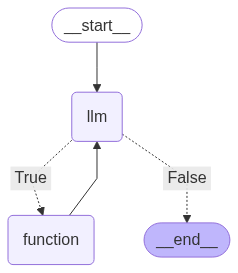

In [122]:
from IPython.display import Image, display

# Visualize the compiled agent graph
display(Image(agent_instance.graph.get_graph().draw_mermaid_png()))